# model_v6

En el "model_v6", se entrena una red neuronal por medio de __Transfer Learning__.

Red neuronal base: 'mobilenet_v3_large_100_224'.

Se aplica 'Data Augmentation'.

Con epoch: 5 > __Recall__: 85,8%

In [10]:
# Funciones
# ================================================================================================================================
import os, sys
sys.path.insert(1, r'C:\Users\gonza\OneDrive\Escritorio\Bootcamp_DS\Alumno\ds_thebridge_1_22\3-Machine_Learning\Entregas\utils')
from funciones import procesamiento_de_datos_X, procesamiento_de_datos_y, define_x_y
from funciones import plot_cm, metricas, plot_roc_curve

# Tratamiento de datos
# ==============================================================================
import os
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Tratamiento de imágenes
# ==============================================================================
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import regularizers  
from keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

# Evaluación del modelo
# ==============================================================================
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# 1. Procesamiento de datos
==================================================================================================

In [11]:
path_train = '../data/processed/train'
path_val = '../data/processed/val'
path_test = '../data/processed/test'
tipos = os.listdir(path_train)

In [12]:
# Definimos variables
X_train, y_train = define_x_y(path_train)
X_val, y_val = define_x_y(path_val)
X_test, y_test = define_x_y(path_test)

In [13]:
# Procesamiento de datos
X_train, X_val, X_test = procesamiento_de_datos_X(X_train, X_val, X_test)
y_train, y_val, y_test = procesamiento_de_datos_y(y_train, y_val, y_test)

# 2. Definición del modelo
==================================================================================================

El modelo __Sequential__ es la forma más fácil de construir un modelo en Keras, una interfaz para la librería TensorFlow. Con este modelo iremos capa por capa, agregándolas mediante la función 'add()'.

## Transfer Learning

Vamos a utilizar como capa de entrada una red neuronal ya entrenada previamente por expertos, disponibles al público en __[TensorFlow Hub](https://tfhub.dev/)__.

In [14]:
# TRANSFER LEARNING: Vamos a utilizar como primeras capas una red neuronal ya entrenada previamente por expertos

base_model = Sequential(
    [hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
                   trainable=False),
    tf.keras.layers.Dense(len(tipos), activation='softmax')
    ])

# 2D Convolutional Neural Network
'''En convulaciones 2D, es recomendable que previamente se haya procesado la imagen en escala de grises (una profundidad). 
No obstante, los datos están a color (tres profundidades), por lo que tendremos que aplicar 3 filtros tridimensionales. 
Del mismo modo, se aplicarán tres convulaciones en lugar de una.'''

#Definición de un modelo sequencial con tres capas
model = Sequential()
input_shape=(224, 224, 3) # (height, width, depth)
chanDim = -1
init="he_normal"
categorias_a_predecir = 4 
reg = regularizers.l2(0.0005) # método de regularización

model.add(base_model)

# Data augmentation (solo aplica durante las llamadas a Model.fit, y no en Model.evaluate o en Model.predict)
Sequential([
  layers.RandomFlip("horizontal_and_vertical"), 
  layers.RandomRotation(0.2), 
])

# Fully-conected layers: copila todas las capas para mostrar un resultado único
model.add(Flatten())
model.add(Dense(512, kernel_initializer=init)) # una capa con 512 nodos se añade al modelo
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# softmax classifier: para predicciones multi-clase
model.add(Dense(categorias_a_predecir))
model.add(Activation("softmax")) # el output serán las predicciones

In [15]:
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenamiento del modelo
==================================================================================================

In [16]:
# fit the model
model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=128, 
                    verbose=2, 
                    # class_weight=class_weights
                    )

Epoch 1/5
27/27 - 82s - loss: 1.2706 - accuracy: 0.5146 - 82s/epoch - 3s/step
Epoch 2/5
27/27 - 71s - loss: 0.5387 - accuracy: 0.7846 - 71s/epoch - 3s/step
Epoch 3/5
27/27 - 62s - loss: 0.4135 - accuracy: 0.8280 - 62s/epoch - 2s/step
Epoch 4/5
27/27 - 66s - loss: 0.3446 - accuracy: 0.8599 - 66s/epoch - 2s/step
Epoch 5/5
27/27 - 64s - loss: 0.2866 - accuracy: 0.8880 - 64s/epoch - 2s/step


### Guardamos el modelo

In [18]:
# Vamos a guardar nuestro modelo
if '../model/model_v6' not in os.listdir():
    model.save('../model/model_v6')

INFO:tensorflow:Assets written to: ../model/model_v6\assets


INFO:tensorflow:Assets written to: ../model/model_v6\assets


In [19]:
# Lo podemos llamar cuando queramos
reconstructed_model = keras.models.load_model('../model/model_v6')

# 4. Evaluación del modelo
==================================================================================================

In [20]:
metricas(y_test, reconstructed_model.predict(X_test))

Accuracy: 0.858
Precision: 0.856
Recall: 0.858


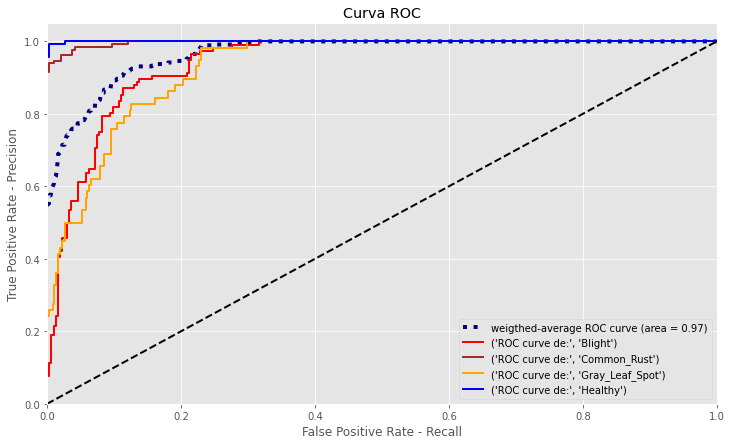

In [21]:
plot_roc_curve(y_test, reconstructed_model.predict(X_test))

In [22]:
# De un vistazo, matriz de confusión
cm = confusion_matrix(y_test, np.argmax(reconstructed_model.predict(X_test), axis=1))
cm_dec = [ cm[i] / np.sum(cm[i]) for i in range(len(cm))]
cm_per = [ [ str(round(x*100,1))+"%" for x in my_list] for my_list in cm_dec ]
cm_per

[['74.1%', '7.8%', '17.2%', '0.9%'],
 ['2.3%', '97.0%', '0.8%', '0.0%'],
 ['34.5%', '5.2%', '60.3%', '0.0%'],
 ['2.6%', '0.0%', '0.0%', '97.4%']]

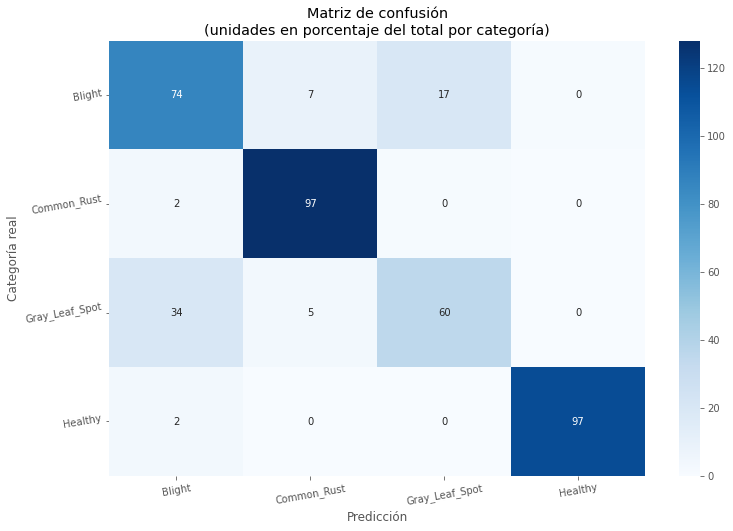

In [23]:
plot_cm(y_test, np.argmax(reconstructed_model.predict(X_test),axis=1))